<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/data-preparation/Dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets
!pip install numpy
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:

import numpy as np
import torch
import random
from datasets import load_dataset
from PIL import Image

#ONLY NEED VAL
val = load_dataset("Maysee/tiny-imagenet", split="valid")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label


# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def tensor_to_pil_image(tensor):
  # Undo normalization
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )
  tensor = unnormalize(tensor)  # Undo normalization
  tensor = tensor.clip(0, 1)  # Clip values to [0, 1] for valid image range
  tensor = tensor.permute(1, 2, 0)  # Rearrange dimensions to (H, W, C)
  return Image.fromarray((tensor.numpy() * 255).astype('uint8'))  # Convert to PIL

In [5]:
val_dataset = ImageNetDataset(val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

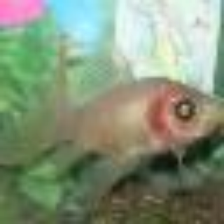

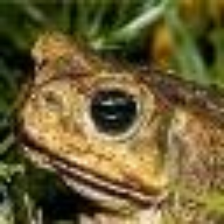

In [ ]:
''' # Retrieve the transformed image from the dataset
transformed_image, label = train_dataset.__getitem__(0)

# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

transformed_image, label = train_dataset.__getitem__(1500)
# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)


display(train_dataset.__getitem__(0)[0])
print(type(train_dataset.__getitem__(0)[0]))
print(np.array(train_dataset.__getitem__(0)[0]).shape)'''

In [4]:
def attack(classifier, image, label, adv_image, steps, checkpoint):
  #assumes that classifier correctly classifies image at beginning
  '''classifier is pretrained imagenet classifier, image is clean input,
  adv_image is random image from other class, label is is correct label of image,
  steps is max # of swaps, checkpoint is check output every X steps
  This outputs the corrupted image'''

  #image_array = np.array(image)
  #adv_array = np.array(adv_image)
  #image = image.to(device)
  #adv_image = adv_image.to(device)
  channel, width, height = image.shape
  #every check_point swaps check if it classifies it correctly

  # Ensure inputs are 4D tensors
  image = image.unsqueeze(0)  # Add batch dimension
  adv_image = adv_image.unsqueeze(0)  # Add batch dimension

  channel, width, height = image.shape[1:]  # Exclude batch dimension
  #print(image.shape, image.shape[1:])
  for i in range(steps):
    if i % checkpoint == 0:
      if classifier != None:
        with torch.no_grad():
          # Pass adv_image through the classifier
          prediction = classifier(adv_image)
          predicted_label = prediction.argmax(dim=1).item()
          if predicted_label != label:
              noised_image = adv_image
              print(f'Step {i}, we fooled the classifier: {predicted_label} != {label}')
              return noised_image.squeeze(0)  # Remove batch dimension
      else:
        pass
        #print(f'Step {i}, not yet fooled.')
    random_x = random.randint(0, height - 1)
    random_y = random.randint(0, width - 1)
    image[:, :, random_x, random_y] = (
        adv_image[:, :, random_x, random_y])
    #display(tensor_to_pil_image(image))

  #all steps done, not fooled
  #print(f'After {steps} steps, not fooled.')
  return image.squeeze(0)  # Return image without batch dimension



In [6]:
from torchvision import models

# Load in pre-trained model
model_path = 'fine_tune_classifier.pth'
model = models.efficientnet_b0(weights="IMAGENET1K_V1")  # Use weights instead of pretrained

# Fix classifier to match pretrained model's layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 200)
# Load  fine-tuned weights
state_dict = torch.load('fine_tune_classifier.pth', weights_only=True, map_location=torch.device('cpu'))

# Load the weights into the model
model.load_state_dict(state_dict)

model.eval()




Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 31.7MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [30]:
from tqdm.notebook import tqdm
def corrected_create_attack_dataset_direct(classifier, dataset, num_classes, attack_fn, steps, checkpoint):

    if classifier is not None:
        classifier.eval()

    attack_dataset = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if classifier is not None:
        classifier.to(device)

    first_image_by_class = {}
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        if label not in first_image_by_class:
            first_image_by_class[label] = (image, idx)
        if len(first_image_by_class) == num_classes:
            break

    for idx in tqdm(range(len(dataset)), dynamic_ncols=True, leave=False, position=0):
        image, label = dataset[idx]
        image = image.to(device)

        next_class = (label + 1) % num_classes
        adv_image, _ = first_image_by_class[next_class]
        adv_image = adv_image.to(device)

        # ATTACK!!!
        corrupted_image = attack_fn(
            classifier=classifier,
            image=image,
            label=label,
            adv_image=adv_image,
            steps=steps,
            checkpoint=checkpoint
        )

        attack_dataset.append((corrupted_image, label))

    return attack_dataset


In [6]:
corrected_val_attack_dataset = corrected_create_attack_dataset_direct(
    classifier=None,
    dataset=val_dataset,
    num_classes=200,
    attack_fn=attack,
    steps=1254,
    checkpoint=500
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
import gzip
import pickle

def save_compressed_dataset(dataset, filename):
    cpu_dataset = [(image.to('cpu'), label) for image, label in dataset]
    with gzip.open(filename, 'wb') as f:
        pickle.dump(cpu_dataset, f)

#save_compressed_dataset(val_dataset, "val_dataset.pkl.gz")
save_compressed_dataset(corrected_val_attack_dataset, "val_1254_attack_dataset.pkl.gz")

In [ ]:
import gzip
import pickle
def load_compressed_dataset(filename):
    with gzip.open(filename, 'rb') as f:
        return pickle.load(f)

loaded_attack_dataset_val = load_compressed_dataset("val_125_attack_dataset.pkl.gz")

EOFError: Compressed file ended before the end-of-stream marker was reached

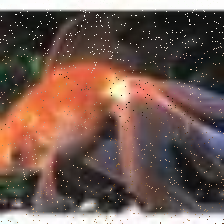

In [ ]:
display(tensor_to_pil_image(corrected_val_attack_dataset[0][0].to('cpu')))

In [26]:
class AttackDataset(Dataset): # FOR CONSISTENCY with ImageNet Dataset
    def __init__(self, data, transform=None):

        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        # Apply normalization transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# attack val - it comes from imagenet transformed data so no transform needed
attack_val_dataset = AttackDataset(corrected_val_attack_dataset)

# Create dataloader
attack_val_dataloader = DataLoader(attack_val_dataset, batch_size=32, shuffle=False)


In [28]:
def test(model, val_dataloader, criterion):
  model.eval()
  correct = 0
  test_loss = 0
  total = 0
  with torch.no_grad():
    for images, labels in tqdm(val_dataloader, dynamic_ncols=True, leave=False, position=0):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f"Test loss: {test_loss/len(val_dataloader.dataset)} | Accuracy: {correct/total}")
  return test_loss/len(val_dataloader.dataset), correct / total


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
# accuracy of regular validation dataset
val_loss, val_accuracy = test(model, val_dataloader, criterion)
print(f"Validation Accuracy (Regular): {val_accuracy:.2f}%")

# accuracy of attack validation dataset
attack_val_loss, attack_val_accuracy = test(model, attack_val_dataloader, criterion)
print(f"Validation Accuracy (Attack): {attack_val_accuracy:.2f}%")


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.028858916193107143 | Accuracy: 0.7957
Validation Accuracy (Regular): 0.80%


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.05805375198796391 | Accuracy: 0.6211
Validation Accuracy (Attack): 0.62%


In [ ]:
# prompt: compute shape of val_dataset and attack_val_dataset from their dataloaders

print(f"Shape of val_dataset: {len(val_dataset)}")
print(f"Shape of attack_val_dataset: {len(corrected_val_attack_dataset)}")

Shape of val_dataset: 10000
Shape of attack_val_dataset: 10000


In [41]:
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

# download an image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image = np.array(image)

# get canny image
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
# pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

# generate image
generator = torch.manual_seed(0)
image = pipe(
    "futuristic-looking woman", num_inference_steps=20, generator=generator, image=canny_image
).images[0]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

(512, 512, 3)


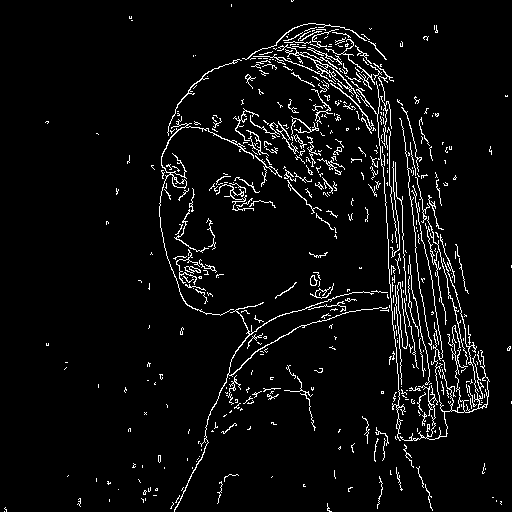

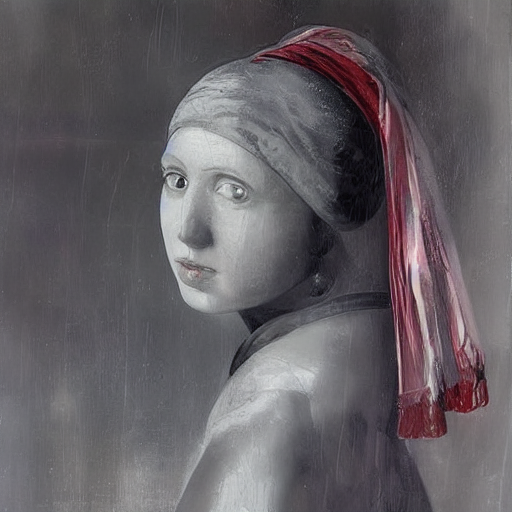

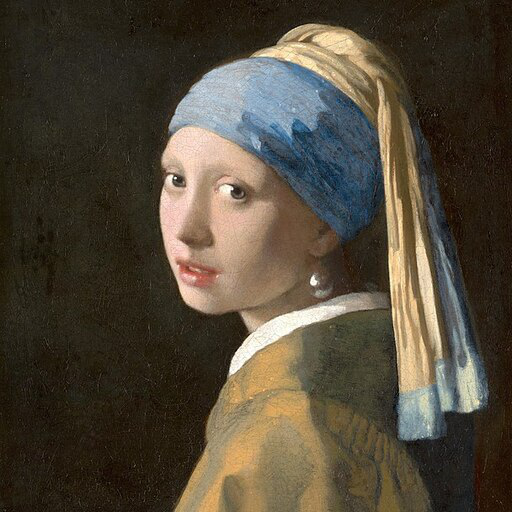

In [18]:
print(np.array(canny_image).shape)
display(canny_image)
display(image)
display(load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
))

In [8]:
generator = torch.manual_seed(0)
image = pipe(
    "", num_inference_steps=20, generator=generator, image=canny_image
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

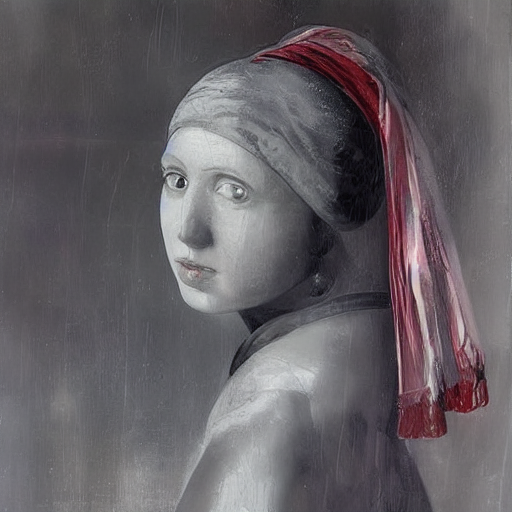

(512, 512, 3)
<class 'PIL.Image.Image'>


In [26]:
display(image)
print(np.array(image).shape)
print(type(image))


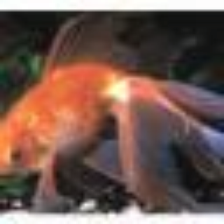

(3, 224, 224)


In [19]:
transformed_image, label = val_dataset.__getitem__(0)
display(tensor_to_pil_image(transformed_image))

reshaped_image = transformed_image.permute(1, 2, 0)

(224, 224, 3)


  0%|          | 0/200 [00:00<?, ?it/s]

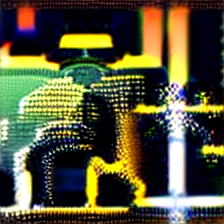

In [43]:
generator = torch.manual_seed(0)
batched_image = tensor_to_pil_image(transformed_image)
print(np.array(batched_image).shape)
image = pipe(
    [""], num_inference_steps=200, generator=generator, image=batched_image, height=224, width=224
).images[0]

display(image)

In [15]:
import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

with open('x_re.pkl', 'rb') as f:
    x_re = CPU_Unpickler(f).load()

with open('x_val.pkl', 'rb') as f:
    x_val = CPU_Unpickler(f).load()

with open('y_val.pkl', 'rb') as f:
    y_val = CPU_Unpickler(f).load()

<ipython-input-15-4881ab4efa3e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu')


In [16]:
print(x_re)
print(x_val)
print(y_val)

tensor([[[[ 1.9071,  1.8291,  1.9031,  ...,  2.0086,  1.9361,  1.9236],
          [ 1.6149,  1.6964,  1.6746,  ...,  1.7784,  1.8410,  1.8430],
          [ 1.7546,  1.6809,  1.7959,  ...,  1.6102,  1.6698,  1.9218],
          ...,
          [ 1.5927,  1.6441,  1.5569,  ..., -0.9496,  0.8429,  1.4961],
          [ 0.6801,  1.5114,  1.5195,  ..., -0.2440, -0.4010, -0.2730],
          [-0.6300,  0.5828,  1.6537,  ...,  1.9516,  1.5818,  1.3902]],

         [[ 1.7511,  1.6822,  1.9443,  ...,  1.8862,  1.8531,  1.8648],
          [ 1.5552,  1.6771,  1.7516,  ...,  1.7324,  1.7891,  1.8455],
          [ 1.7521,  1.7898,  1.9070,  ...,  1.7272,  1.7578,  1.8307],
          ...,
          [ 1.4403,  1.7654,  1.6942,  ..., -1.6236,  0.2962,  1.3234],
          [-0.0717,  1.4613,  1.6978,  ..., -0.7978, -0.9184, -0.7461],
          [-1.4554, -0.2837,  1.4669,  ...,  1.7285,  1.4065,  1.3917]],

         [[ 2.4107,  2.3312,  2.5510,  ...,  2.4793,  2.1615,  2.3058],
          [ 1.9497,  2.1535,  

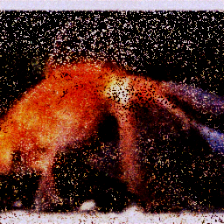

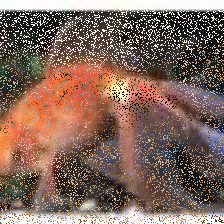

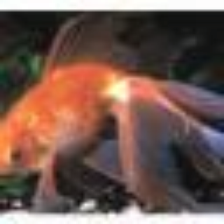

In [21]:
display(tensor_to_pil_image(x_re[0].detach()))
display(tensor_to_pil_image(x_val[0].detach()))
display(tensor_to_pil_image(val_dataset.__getitem__(0)[0]))

In [24]:
x_re_list = list(x_re)
x_val_list = list(x_val)
y_val_list = list(y_val)

zipped_data_attack = list(zip(x_val_list, y_val_list))
zipped_data_pure = list(zip(x_re_list, y_val_list))


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

five_original = AttackDataset(image_label_list)
five_attack = AttackDataset(zipped_data_attack)
five_pure = AttackDataset(zipped_data_pure)
#dataloaders
five_original_dataloader = DataLoader(five_original, batch_size=5, shuffle=False)
attack_val_dataloader = DataLoader(five_attack, batch_size=5, shuffle=False)
pure_val_dataloader = DataLoader(five_pure, batch_size=5, shuffle=False)
criterion = torch.nn.CrossEntropyLoss()

# accuracy of regular validation dataset
val_loss, val_accuracy = test(model, five_original_dataloader, criterion)
print(f"Validation Accuracy (Regular): {val_accuracy:.2f}%")

val_loss, val_accuracy = test(model, attack_val_dataloader, criterion)
print(f"Validation Accuracy (Regular): {val_accuracy:.2f}%")

val_loss, val_accuracy = test(model, pure_val_dataloader, criterion)
print(f"Validation Accuracy (Regular): {val_accuracy:.2f}%")

  0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.38833889961242674 | Accuracy: 0.6
Validation Accuracy (Regular): 0.60%


  0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 1.615091323852539 | Accuracy: 0.0
Validation Accuracy (Regular): 0.00%


  0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 1.3890830993652343 | Accuracy: 0.0
Validation Accuracy (Regular): 0.00%


In [33]:
import os

extract_folder = "/content/purification_150"
os.makedirs(extract_folder, exist_ok=True)
import zipfile


zip_file_path = "/content/purification_150.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Extracted to: {extract_folder}")


Extracted to: /content/purification_150


In [36]:
# Path
pkl_folder = "/content/purification_150/content/IML-Team-Attack-Diffusion-Model/output/x_re"

all_data_re = []

for file_name in sorted(os.listdir(pkl_folder)):
    if file_name.startswith("iter_") and file_name.endswith(".pkl"):
        file_path = os.path.join(pkl_folder, file_name)

        with open(file_path, 'rb') as f:
            data = CPU_Unpickler(f).load()

        all_data_re.extend(data)

print(f"Total elements concatenated: {len(all_data_re)}")

''''''


pkl_folder = "/content/purification_150/content/IML-Team-Attack-Diffusion-Model/output/x_val"


all_data_val = []

for file_name in sorted(os.listdir(pkl_folder)):
    if file_name.startswith("iter_") and file_name.endswith(".pkl"):
        file_path = os.path.join(pkl_folder, file_name)


        with open(file_path, 'rb') as f:
            data = CPU_Unpickler(f).load()


        all_data_val.extend(data)

print(f"Total elements concatenated: {len(all_data_val)}")

''''''


pkl_folder = "/content/purification_150/content/IML-Team-Attack-Diffusion-Model/output/y_val"


all_y_val = []


for file_name in sorted(os.listdir(pkl_folder)):
    if file_name.startswith("iter_") and file_name.endswith(".pkl"):
        file_path = os.path.join(pkl_folder, file_name)

        with open(file_path, 'rb') as f:
            data = CPU_Unpickler(f).load()

        all_y_val.extend(data)

print(f"Total elements concatenated: {len(all_y_val)}")


#Done! a lot of copy pasted stuff but only need to do it once

<ipython-input-15-4881ab4efa3e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu')


Total elements concatenated: 150
Total elements concatenated: 150
Total elements concatenated: 150


In [41]:
all_data_re_list = list(all_data_re)
all_data_val_list = list(all_data_val)
all_y_val_list = list(all_y_val)

all_zipped_data_pure = list(zip(all_data_re_list, all_y_val_list))
all_zipped_data_attack = list(zip(all_data_val_list, all_y_val_list))

In [43]:
all_attack_val_dataloader = DataLoader(all_zipped_data_attack, batch_size=32, shuffle=False)
all_pure_val_dataloader = DataLoader(all_zipped_data_pure, batch_size=32, shuffle=False)
criterion = torch.nn.CrossEntropyLoss()

# accuracy of regular validation dataset

val_loss, val_accuracy = test(model, all_attack_val_dataloader, criterion)
print(f"Validation Accuracy (Attack): {val_accuracy:.2f}%")

val_loss, val_accuracy = test(model, all_pure_val_dataloader, criterion)
print(f"Validation Accuracy (Pure): {val_accuracy:.2f}%")

  0%|          | 0/5 [00:00<?, ?it/s]

Test loss: 0.22626578330993652 | Accuracy: 0.013333333333333334
Validation Accuracy (Attack): 0.01%


  0%|          | 0/5 [00:00<?, ?it/s]

Test loss: 0.31337059020996094 | Accuracy: 0.006666666666666667
Validation Accuracy (Pure): 0.01%
